In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage import io, transform
import utils_xy
from torchvision import transforms, utils
import numpy as np
from PIL import Image

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print (device)

cuda


In [3]:
# load the training images and the semantic segmentation image (mask image)
train = '/home/xiaoyu/BMMC/BMMCdata'
train_mask = '/home/xiaoyu/BMMC/BMMCmasks'

trainimage = sorted(os.listdir(train))
trainmask = sorted(os.listdir(train_mask))

print("Training images numbers: "+str(len(trainimage)))
print("Training mask Images numbers:"+str(len(trainmask)))

Training images numbers: 43
Training mask Images numbers:43


In [4]:
image_ex = trainimage[1]
mask_ex = trainmask[1]
print(io.imread(os.path.join(train, image_ex)).dtype)
print(io.imread(os.path.join(train, image_ex)).shape)
print(io.imread(os.path.join(train_mask, mask_ex)).shape)

uint16
(1024, 1024, 3)
(1024, 1024)


In [5]:
def show_semantic(image, semantic):
    """
    Show images with semantic segmentation
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The traing image semantic segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image, aspect='auto')
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(semantic, aspect='auto')
    plt.show()

In [6]:
class TrainDataset(Dataset):
    """Training dataset with mask image mapping to classes"""
    def __init__(self, train_dir, semantic_dir, transform=None):
        """
        Args:
            train_dir (string): Directory with training images
            transform (callable): Optional transform to be applied on a sample
            semantic_dir (string): Directory with semantic segmentation training image
        """
        self.train_dir = train_dir
        self.transform = transform
        self.semantic_dir = semantic_dir
        self.mapping = {
            85: 0,
            170: 1,
            255: 2
        }
        
    def mask_to_class(self, semantic):
        for k in self.mapping:
            semantic[semantic==k] = self.mapping[k]
        return semantic
        
    def __len__(self):
        return len(os.listdir(self.train_dir))
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.train_dir, sorted(os.listdir(self.train_dir))[idx])
        semantic_name = os.path.join(self.semantic_dir, sorted(os.listdir(self.semantic_dir))[idx])
        image = np.uint8(io.imread(img_name))
        semantic = io.imread(semantic_name)
        
        semantic = torch.from_numpy(np.array(semantic))
        semantic = self.mask_to_class(semantic)
        sample = {'image':image, 'semantic':semantic}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

torch.Size([1024, 1024])
(1024, 1024, 3)


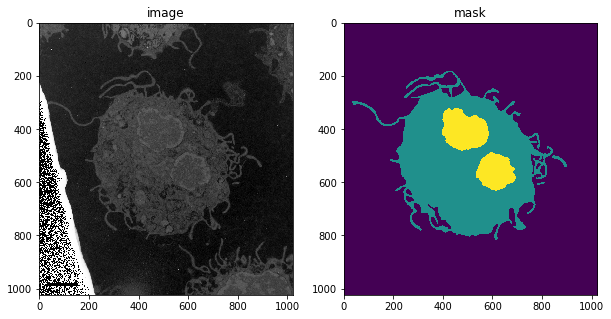

torch.Size([1024, 1024])
(1024, 1024, 3)


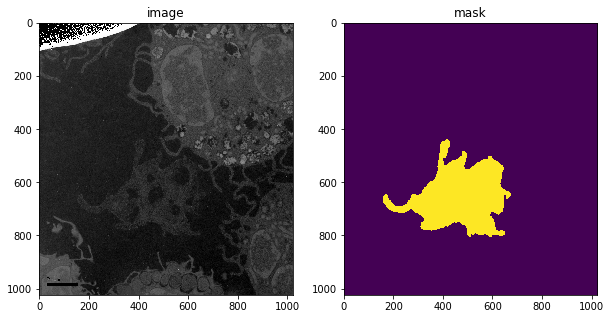

torch.Size([1024, 1024])
(1024, 1024, 3)


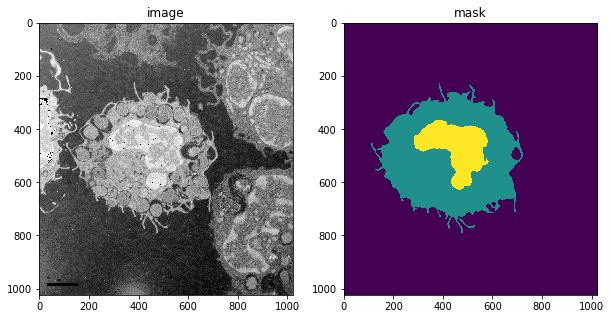

In [7]:
# test the traindataset class without data preprocessing
train_data = TrainDataset(train_dir=train, semantic_dir =train_mask)

for i in range(len(train_data)):
    sample = train_data[i]
#     print(i, sample['image'].dtype, sample['semantic'].dtype)
    print(sample['semantic'].shape)
    print(sample['image'].shape)
    plt.figure(figsize=(10, 5))
    show_semantic(sample['image'],sample['semantic'])
    
    if i == 2:  
        break

In [8]:
class ToTensor(object):
    """Convert ndarrays in sample (both the original image 
    and the semantic image to Tensors"""
    
    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']  
        #swap color axis because
        #numpy image: H x W x C
        #torch image: C x H x W
        image = image.transpose((2, 0, 1))
        semantic = semantic
        return {'image': torch.from_numpy(image),
                'semantic': semantic}

In [9]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, semantic = sample['image'],sample['semantic']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        semantic = semantic[top: top + new_h, left: left + new_w]

        return {'image': image, 'semantic': semantic}

The original image:


<Figure size 432x288 with 0 Axes>

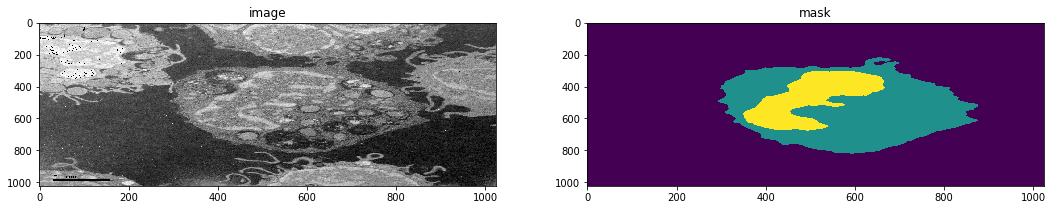

The cropped image:


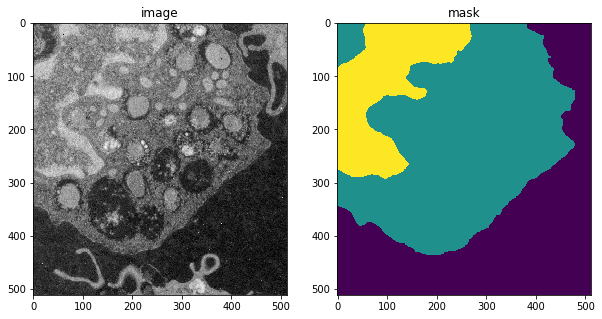

In [10]:
# test of the tress preprocessing of the image functions
crop = RandomCrop(512)

fig = plt.figure()
sample = train_data[3]

print("The original image:")
plt.figure(figsize=(18, 3))
show_semantic(**sample)

print("The cropped image:")
croped_sample = crop(sample)
plt.figure(figsize=(10, 5))
show_semantic(**croped_sample)

In [11]:
composed = transforms.Compose([RandomCrop(512), ToTensor()])
transformed_dataset = TrainDataset(train_dir=train, semantic_dir =train_mask, transform = composed)

In [12]:
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    print(i, sample['image'].shape, sample['semantic'].shape)
    
    if i == 2:  
        break

0 torch.Size([3, 512, 512]) torch.Size([512, 512])
1 torch.Size([3, 512, 512]) torch.Size([512, 512])
2 torch.Size([3, 512, 512]) torch.Size([512, 512])


In [13]:
dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle = False, num_workers = 4)

In [14]:
print(len(dataloader))

43


In [15]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch)
    print(sample_batched['image'].size())
    if i_batch ==0:
        break

0
torch.Size([1, 3, 512, 512])


In [16]:
class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(BaseConv, self).__init__()

        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, padding,
                               stride)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size,
                               padding, stride)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

In [17]:
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding,
                 stride):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size,
                                   padding, stride)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x

In [18]:
class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels,
                 kernel_size, padding, stride):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(
            in_channels, in_channels, kernel_size=2, padding=0, stride=2)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=padding,
            stride=stride)

    def forward(self, x, x_skip):
        x = self.conv_trans1(x)
        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x


In [19]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size,
                 padding, stride):
        super(UNet, self).__init__()

        self.init_conv = BaseConv(in_channels, out_channels, kernel_size,
                                  padding, stride)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size,
                              padding, stride)

        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size,
                              padding, stride)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size,
                              padding, stride)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels,
                          kernel_size, padding, stride)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels,
                          kernel_size, padding, stride)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels,
                          kernel_size, padding, stride)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, padding, stride)

    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)
        x_out = F.log_softmax(self.out(x_up), 1)
        return x_out

In [20]:
unet = UNet(in_channels=3,
             out_channels=64,
             n_class=3,
             kernel_size=3,
             padding=1,
             stride=1)

In [21]:
print(unet)
unet_params = list(unet.parameters())
print("The length of the unet parameter is: ")
print(len(unet_params))
print("The conv1's weight: ")
print(unet_params[0].size()) # conv1's weight  0.4.
print("The weight's dtype: ")
print(unet_params[0].dtype)

UNet(
  (init_conv): BaseConv(
    (act): ReLU()
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down1): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (down2): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (down3): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block)

In [22]:
current_device = torch.cuda.current_device()
torch.cuda.device(current_device)

In [23]:
torch.cuda.device_count()

1

In [24]:
torch.cuda.get_device_name(0)

'GeForce GTX 1080 Ti'

In [25]:
unet = unet.to(device)

In [26]:
print(unet_params[0].dtype)

torch.float32


The inputs is: 
tensor([[[[-1.3309, -1.4747, -0.8518,  ..., -1.5705, -1.2830, -1.6664],
          [-1.1872, -1.6185, -1.1872,  ..., -1.2830, -1.4747, -1.4268],
          [-1.0914, -1.4268, -1.3309,  ..., -1.2351, -1.2830, -1.4268],
          ...,
          [-1.5226, -1.0914, -1.1872,  ..., -1.6664, -1.3789, -1.4268],
          [-0.9955, -1.0914, -1.1872,  ..., -2.0497, -2.0977, -2.0497],
          [-1.1872, -1.1872, -1.0914,  ..., -1.6185, -2.1456, -2.0977]],

         [[-1.3309, -1.4747, -0.8518,  ..., -1.5705, -1.2830, -1.6664],
          [-1.1872, -1.6185, -1.1872,  ..., -1.2830, -1.4747, -1.4268],
          [-1.0914, -1.4268, -1.3309,  ..., -1.2351, -1.2830, -1.4268],
          ...,
          [-1.5226, -1.0914, -1.1872,  ..., -1.6664, -1.3789, -1.4268],
          [-0.9955, -1.0914, -1.1872,  ..., -2.0497, -2.0977, -2.0497],
          [-1.1872, -1.1872, -1.0914,  ..., -1.6185, -2.1456, -2.0977]],

         [[-1.3309, -1.4747, -0.8518,  ..., -1.5705, -1.2830, -1.6664],
          [-1.

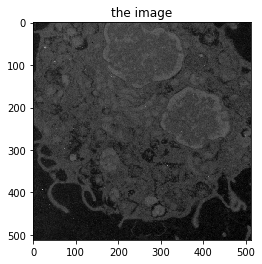

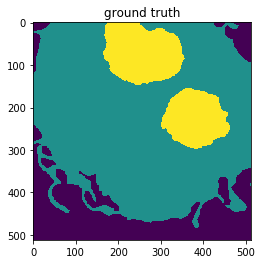

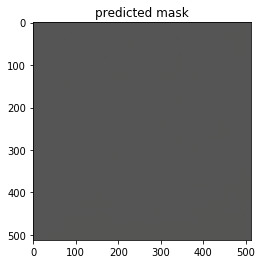

In [29]:
for i_batch, sample_batched in enumerate(dataloader):
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)   #class 0,1,2
    
    mean_inputs = torch.mean(inputs_float)
    inputs_final = inputs_float - mean_inputs
    inputs_final /= torch.std(inputs_final)
   
    print("The inputs is: ")
    print(inputs_final)
    
    print('\n The groundtruth label is: ')
    print(labels_float)
   
    outputs = unet(inputs_final.cuda())
    print("\n The output is: ")
    outputs_prop = torch.exp(outputs)
    print(outputs_prop)
    
    
    #Visualisaton
    image_in = inputs_float.detach().squeeze().permute(1,2,0)
    image_mask = labels_float.detach().squeeze()
    image_out = outputs_prop.detach().squeeze().permute(1,2,0)

    plt.imshow(image_in.type(torch.ByteTensor))
    plt.title("the image")
    plt.pause(1)
    
    plt.imshow(image_mask)
    plt.title("ground truth")
    plt.pause(1)
    
    plt.imshow(image_out)
    plt.title("predicted mask")
    plt.pause(1)
    
    if i_batch == 0:
        
        break

In [41]:
criterion = nn.NLLLoss()
mylr = 0.25

In [47]:
for epoch in range(100):
    # loop over the dataset 1 times
    
    running_loss = 0.0
    if epoch%5==4:
        mylr = mylr/5
    optimizer = optim.SGD(unet.parameters(),
                      lr=mylr,
                      momentum=0.9,
                      weight_decay=0.0005)
    for i_batch, sample_batched in enumerate(dataloader):
        
        #get the inputs
        inputs, labels = sample_batched['image'], sample_batched['semantic']
        inputs_float = inputs.type(torch.FloatTensor)

        mean_inputs = torch.mean(inputs_float)
        inputs_final = inputs_float - mean_inputs
        inputs_final /= torch.std(inputs_final)
      
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward +optimize
        outputs = unet(inputs_final.cuda())

        # Define the loss
        loss = criterion(outputs, labels.long().cuda()) 
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i_batch%43 == 42: 
            # print every 5 mini-batchs
            print('[%d, %5f] loss: %.3f'%(epoch +1, i_batch+1, running_loss/43))
            running_loss = 0.0
print('Finish Training')

[1, 43.000000] loss: 0.784
[2, 43.000000] loss: 0.784
[3, 43.000000] loss: 0.784
[4, 43.000000] loss: 0.784
[5, 43.000000] loss: 0.784
[6, 43.000000] loss: 0.784
[7, 43.000000] loss: 0.784
[8, 43.000000] loss: 0.784
[9, 43.000000] loss: 0.784
[10, 43.000000] loss: 0.784
[11, 43.000000] loss: 0.784
[12, 43.000000] loss: 0.784
[13, 43.000000] loss: 0.784
[14, 43.000000] loss: 0.784
[15, 43.000000] loss: 0.784
[16, 43.000000] loss: 0.784
[17, 43.000000] loss: 0.784
[18, 43.000000] loss: 0.784
[19, 43.000000] loss: 0.784
[20, 43.000000] loss: 0.784
[21, 43.000000] loss: 0.784
[22, 43.000000] loss: 0.784
[23, 43.000000] loss: 0.784
[24, 43.000000] loss: 0.784
[25, 43.000000] loss: 0.784
[26, 43.000000] loss: 0.784
[27, 43.000000] loss: 0.784
[28, 43.000000] loss: 0.784
[29, 43.000000] loss: 0.784
[30, 43.000000] loss: 0.784
[31, 43.000000] loss: 0.784
[32, 43.000000] loss: 0.784


Process Process-340:
Process Process-338:
Process Process-337:
Process Process-339:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/process.py", line 93, in run
    self

KeyboardInterrupt: 

  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/home/xiaoyu/miniconda3/envs/deep_mol/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    b

The inputs is: 
tensor([[[[  24.,   21.,   34.,  ...,   19.,   25.,   17.],
          [  27.,   18.,   27.,  ...,   25.,   21.,   22.],
          [  29.,   22.,   24.,  ...,   26.,   25.,   22.],
          ...,
          [  20.,   29.,   27.,  ...,   17.,   23.,   22.],
          [  31.,   29.,   27.,  ...,    9.,    8.,    9.],
          [  27.,   27.,   29.,  ...,   18.,    7.,    8.]],

         [[  24.,   21.,   34.,  ...,   19.,   25.,   17.],
          [  27.,   18.,   27.,  ...,   25.,   21.,   22.],
          [  29.,   22.,   24.,  ...,   26.,   25.,   22.],
          ...,
          [  20.,   29.,   27.,  ...,   17.,   23.,   22.],
          [  31.,   29.,   27.,  ...,    9.,    8.,    9.],
          [  27.,   27.,   29.,  ...,   18.,    7.,    8.]],

         [[  24.,   21.,   34.,  ...,   19.,   25.,   17.],
          [  27.,   18.,   27.,  ...,   25.,   21.,   22.],
          [  29.,   22.,   24.,  ...,   26.,   25.,   22.],
          ...,
          [  20.,   29.,   27.,  ..

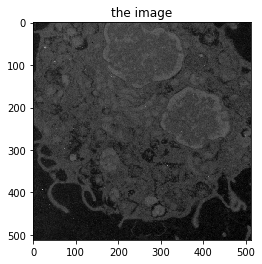

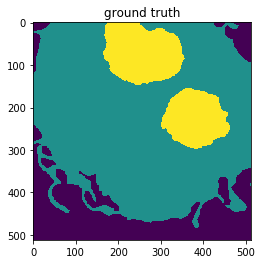

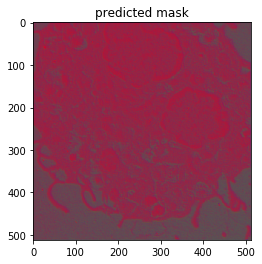

In [30]:
for i_batch, sample_batched in enumerate(dataloader):
    
    # Prepare the data
    inputs, labels = sample_batched['image'], sample_batched['semantic']
    inputs_float = inputs.type(torch.FloatTensor)
    labels_float = labels.type(torch.FloatTensor)
    
    print("The inputs is: ")
    print(inputs_float)
    
    print('\n The groundtruth label is: ')
    print(labels_float)
   
    outputs = unet(inputs_float.cuda())
    print("\n The output is: ")
    print(outputs.dtype)
    outputs_prop = torch.exp(outputs)
    print(outputs_prop)
    
    print("The image size is: "+ str(inputs_float.size()) + ". The inputs data type is: " + str(inputs_float.dtype))
    print("The groundtruth mask size is :"+ str(labels.size()) + ". The groundtruth mask type is: " + str(labels_float.dtype))
    print("The predicted mask size is :" +str(outputs.size()) + ". The predicted mask type is " + str(outputs.dtype))
    
    
    #Visualisaton
    image_in = inputs_float.detach().squeeze().permute(1,2,0)
    image_mask = labels_float.detach().squeeze()
    image_out = outputs_prop.detach().squeeze().permute(1,2,0)
    
#
    plt.imshow(image_in.type(torch.ByteTensor))
    plt.title("the image")
    plt.pause(1)
    
    plt.imshow(image_mask)
    plt.title("ground truth")
    plt.pause(1)
    
    plt.imshow(image_out)
    plt.title("predicted mask")
    plt.pause(1)
    
    if i_batch == 0:
        
        break